# II. MACHINE LEARNING MODEL SELECTION

### Importing final_df from previous notebook

In [1]:
%store -r final_df joined_df final_kaggle_test_df

### Importing all required packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
)
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.compose import (
    make_column_selector as selector,
    make_column_transformer,
)
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    cross_val_predict,
    train_test_split,
)
from sklearn.compose import ColumnTransformer

## Spliting dataset into train and validation set
Dataset will be divided on train and validation set (80/20)

In [ ]:
X = final_df.drop(columns=["TARGET"])
y = final_df["TARGET"]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Model selection

Creating a template for summary dataframe
The scores used to evaluate models are: Accuracy, Balanced accuracy, ROC AUC, F1 score and recall.
Metrics were chosen in order to measure the ability of the classifier to find as manya as possible positive samples (clients with financial difficulties)

In [ ]:
index = []
scores = {
    "Accuracy": [],
    "Balanced accuracy": [],
    "AUC": [],
    "F1 score": [],
    "Recall": [],
}

scoring = ["accuracy", "balanced_accuracy", "roc_auc", "f1", "recall"]

Creating a function for updating the summary table

In [ ]:
def update_summary_table(cv_result, scores, classifier, index):
    """ " Update the summary table with cross-validation results

    :param cv_result: results for cross_validate function with scoring as metrics
    :type cv_result: dict
    :param scores: dictionary to store scores for each classifier to be transformed to DataFrame
    :type scores: dict
    :param classifier: classifier name or object to be added to the index of the DataFrame
    :type classifier: str
    :param index: list of classifiers to be used as index in the DataFrame
    :type index: list
    :return: DataFrame with scores for each classifier
    :rtype: pd.DataFrame
    """
    index += [classifier]
    scores["Accuracy"].append(cv_result["test_accuracy"].mean())
    scores["Balanced accuracy"].append(
        cv_result["test_balanced_accuracy"].mean()
    )
    scores["AUC"].append(cv_result["test_roc_auc"].mean())
    scores["F1 score"].append(cv_result["test_f1"].mean())
    scores["Recall"].append(cv_result["test_recall"].mean())
    df_scores = pd.DataFrame(scores, index=index)
    return df_scores

### Setting up preprocessing strategy 
#### For linear ML models
Creating a preprocessor which will dispatch the categorical columns to the categorical pipeline and the numerical columns to the numerical pipeline. For linear models, we will need to **one-hot encode** the categorical columns and **standardized** the numerical columns before to inject the data into the classifier


In [7]:
num_pipe = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)
cat_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

preprocessor_linear = make_column_transformer(
    (num_pipe, selector(dtype_include="number")),
    (cat_pipe, selector(dtype_include="category")),
    n_jobs=2,
)
preprocessor_linear

ColumnTransformer(n_jobs=2,
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001DCA5671890>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001DCA5671990>)])

#### For tree-base ML models
With this type of classifiers, we will not need to scale the numerical data, and we will only need to **ordinal encode** the categorical data.
Imputing strategy for Nans values for numerical columns is **median**
Imputing strategy for Nans values for categorical columns is **most_frequent**

In [8]:
num_pipe = SimpleImputer(strategy="median", add_indicator=True)
cat_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(),
)

preprocessor_tree = make_column_transformer(
    (num_pipe, selector(dtype_include="number")),
    (cat_pipe, selector(dtype_include="category")),
    n_jobs=2,
)
preprocessor_tree

ColumnTransformer(n_jobs=2,
                  transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True,
                                               strategy='median'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001DCA567C9D0>),
                                ('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001DCA567C910>)])

### Setting up Baseline 
#### DummyClassifier

The baseline might might be set using Dummy classifier

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")

cv_result = cross_validate(dummy_clf, X_train, y_train, scoring=scoring, cv=3)
update_summary_table(cv_result, scores, "DummyClassifier", index)

,Accuracy,Balanced accuracy,AUC,F1 score,Recall
DummyClassifier,0.919539,0.5,0.5,0.0,0.0


Due to dataset imbalance and high content of solvent credit takers, if we blindly assume that all customers and credit applicants will not have any payment difficulties, we will be right in almost 92%! That is a lot and statistics are by our site but what if the rest of customers (~8%) did not pay credit installment at all? That might eliminate bank's profits and might be a huge problem.

This is why we should set our baseline another way
For further analysis we wil use balanced accuracy, ROC AUC, F1 score and recall.

#### CustomClassifier - EXT_SOURCE average
For another baseline we can use EXT_SOURCE_* features. Below, for each sample the mean from all 3 EXT_SOURCE scores will be calculated. Dummy classifier for samples with mean score above 0.5 will predict classify them to 0 and for mean below 0.5: 1 (The higher EXT_SOURCE score, the lower credit risk)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate


# Custom transformer to calculate the average of EXT_SOURCE scores
class EXTSourceAverageTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        avg_ext_source = X[
            ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]
        ].mean(axis=1)
        return avg_ext_source.values.reshape(-1, 1)


# Custom classifier to predict based on avg_ext_source
class CustomDummyClassifier(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return (X.flatten() < 0.5).astype(int)

    def predict_proba(self, X):
        """Return probabilities for each class."""
        proba = np.zeros((X.shape[0], 2))
        proba[:, 1] = X.flatten()  # Probability of class 1
        proba[:, 0] = 1 - proba[:, 1]  # Probability of class 0
        return proba


# Define the pipeline
custom_transformer = EXTSourceAverageTransformer()
custom_clf = CustomDummyClassifier()

pipeline = Pipeline(
    [("ext_source_avg", custom_transformer), ("custom_classifier", custom_clf)]
)

# Cross-validate the pipeline
cv_result = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=3)

# Update the summary table
update_summary_table(cv_result, scores, "Custom DummyClassifier", index)

,Accuracy,Balanced accuracy,AUC,F1 score,Recall
DummyClassifier,0.919539,0.500000,0.5,0.000000,0.000000
Custom DummyClassifier,0.597692,0.656145,NaN,0.224992,0.725806


- Based only od EXT_SOURCE and setting up threshold on 0.5, we can get quite high baseline metrics

### GOAL: Beat 0,66 balanced accuracy score and create a better predictor then classifier based only on scores from external sources

### Logistic Regression  

In [11]:
%%time
log_reg_pipe = make_pipeline(
    preprocessor_linear, LogisticRegression(class_weight="balanced", max_iter=5000, random_state=42)
)

cv_result = cross_validate(log_reg_pipe, X_train, y_train, scoring=scoring, cv = 3)
update_summary_table(cv_result, scores, "Logistic Reg.", index)

CPU times: total: 15.8 s
Wall time: 21 s


,Accuracy,Balanced accuracy,AUC,F1 score,Recall
DummyClassifier,0.919539,0.500000,0.500000,0.000000,0.000000
Custom DummyClassifier,0.597692,0.656145,NaN,0.224992,0.725806
Logistic Reg.,0.684941,0.683334,0.744611,0.258180,0.681419


- Logistic regression did quite a good job but it is more time consuming.

### Light Gradient Boosted Machine (LightGBM)

In [12]:
%%time
from lightgbm import LGBMClassifier

for col in X_train.select_dtypes(include="object").columns:
        X_train[col] = X_train[col].astype("category")

LightGBM_clf = LGBMClassifier(class_weight="balanced", verbose=0, random_state=42)

cv_result = cross_validate(
        LightGBM_clf, X_train, y_train, scoring=scoring
    )
update_summary_table(cv_result, scores, "LightGBM", index)

CPU times: total: 54.1 s
Wall time: 36.4 s


,Accuracy,Balanced accuracy,AUC,F1 score,Recall
DummyClassifier,0.919539,0.500000,0.500000,0.000000,0.000000
Custom DummyClassifier,0.597692,0.656145,NaN,0.224992,0.725806
Logistic Reg.,0.684941,0.683334,0.744611,0.258180,0.681419
LightGBM,0.719464,0.696620,0.763349,0.277454,0.669395


- The model performs better than previous one but is a little bit slower

### DecisionTreeClassifier

In [13]:
%%time
from sklearn.tree import DecisionTreeClassifier

DecisionTreeClassifier_pipe = make_pipeline(
    preprocessor_linear, DecisionTreeClassifier(class_weight="balanced")
)

cv_result = cross_validate(
        DecisionTreeClassifier_pipe, X_train, y_train, cv=3, scoring=scoring
    )

update_summary_table(cv_result, scores, "Decision tree", index)

CPU times: total: 52.7 s
Wall time: 1min 5s


,Accuracy,Balanced accuracy,AUC,F1 score,Recall
DummyClassifier,0.919539,0.500000,0.500000,0.000000,0.000000
Custom DummyClassifier,0.597692,0.656145,NaN,0.224992,0.725806
Logistic Reg.,0.684941,0.683334,0.744611,0.258180,0.681419
LightGBM,0.719464,0.696620,0.763349,0.277454,0.669395
Decision tree,0.855936,0.540097,0.540097,0.154571,0.163686


- Rejected

### XGBoost

In [14]:
%%time
from xgboost import XGBClassifier

sum_wpos = sum(y_train ==1)
sum_wneg = sum(y_train ==0)

xgb_clf = make_pipeline(
    preprocessor_tree, XGBClassifier(scale_pos_weight = sum_wneg/sum_wpos, random_state=42)
)

cv_result = cross_validate(
        xgb_clf, X_train, y_train, cv=5, scoring=scoring
    )

update_summary_table(cv_result, scores, "XGBoost", index)

CPU times: total: 1min 9s
Wall time: 41.1 s


,Accuracy,Balanced accuracy,AUC,F1 score,Recall
DummyClassifier,0.919539,0.500000,0.500000,0.000000,0.000000
Custom DummyClassifier,0.597692,0.656145,NaN,0.224992,0.725806
Logistic Reg.,0.684941,0.683334,0.744611,0.258180,0.681419
LightGBM,0.719464,0.696620,0.763349,0.277454,0.669395
Decision tree,0.855936,0.540097,0.540097,0.154571,0.163686
XGBoost,0.746260,0.683807,0.748000,0.278757,0.609376


- xgboost performs very well but still worst then lightGBM

### LightGBM with undersampling
Since LightGBM is the best model so far, we might check its performance with sampling strategies for imbalanced dataset

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler

LightGBM_under_pipe = make_pipeline_with_sampler(
    RandomUnderSampler(random_state=42), LightGBM_clf
)

cv_result = cross_validate(
    LightGBM_under_pipe, X_train, y_train, scoring=scoring, cv=3
)
update_summary_table(cv_result, scores, "Light GBM + UnderSampling", index)

,Accuracy,Balanced accuracy,AUC,F1 score,Recall
DummyClassifier,0.919539,0.500000,0.500000,0.000000,0.000000
Custom DummyClassifier,0.597692,0.656145,NaN,0.224992,0.725806
Logistic Reg.,0.684941,0.683334,0.744611,0.258180,0.681419
LightGBM,0.719464,0.696620,0.763349,0.277454,0.669395
Decision tree,0.855936,0.540097,0.540097,0.154571,0.163686
XGBoost,0.746260,0.683807,0.748000,0.278757,0.609376
Light GBM + UnderSampling,0.695193,0.695063,0.759311,0.268399,0.694908


- Undersampling technic increased recall but balanced accuracy and ROC AUC are slightly worst then for pure Light GBM

### Balanced Random Forest

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

rf_clf = make_pipeline(
    preprocessor_tree,
    BalancedRandomForestClassifier(
        sampling_strategy="all",
        replacement=True,
        bootstrap=False,
        random_state=42,
        n_jobs=2,
    ),
)
cv_result = cross_validate(rf_clf, X_train, y_train, scoring=scoring, cv=3)
update_summary_table(
    cv_result, scores, "BalancedRandomForestClassifier", index
)

,Accuracy,Balanced accuracy,AUC,F1 score,Recall
DummyClassifier,0.919539,0.500000,0.500000,0.000000,0.000000
Custom DummyClassifier,0.597692,0.656145,NaN,0.224992,0.725806
Logistic Reg.,0.684941,0.683334,0.744611,0.258180,0.681419
LightGBM,0.719464,0.696620,0.763349,0.277454,0.669395
Decision tree,0.855936,0.540097,0.540097,0.154571,0.163686
XGBoost,0.746260,0.683807,0.748000,0.278757,0.609376
Light GBM + UnderSampling,0.695193,0.695063,0.759311,0.268399,0.694908
BalancedRandomForestClassifier,0.811100,0.665219,0.748948,0.295087,0.491361


### Balanced bag of histogram gradient boosting

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

bag_clf = make_pipeline(
    preprocessor_tree,
    BalancedBaggingClassifier(
        estimator=HistGradientBoostingClassifier(random_state=42),
        n_estimators=10,
        random_state=42,
        n_jobs=2,
    ),
)

cv_result = cross_validate(bag_clf, X_train, y_train, scoring=scoring, cv=3)
update_summary_table(
    cv_result, scores, "Balanced bag of histogram gradient boosting", index
)

,Accuracy,Balanced accuracy,AUC,F1 score,Recall
DummyClassifier,0.919539,0.500000,0.500000,0.000000,0.000000
Custom DummyClassifier,0.597692,0.656145,NaN,0.224992,0.725806
Logistic Reg.,0.684941,0.683334,0.744611,0.258180,0.681419
LightGBM,0.719464,0.696620,0.763349,0.277454,0.669395
Decision tree,0.855936,0.540097,0.540097,0.154571,0.163686
XGBoost,0.746260,0.683807,0.748000,0.278757,0.609376
Light GBM + UnderSampling,0.695193,0.695063,0.759311,0.268399,0.694908
BalancedRandomForestClassifier,0.811100,0.665219,0.748948,0.295087,0.491361
Balanced bag of histogram gradient boosting,0.716204,0.697498,0.763894,0.276862,0.675205


### LightGBM with SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler

LightGBM_SMOTE_pipe = make_pipeline_with_sampler(
    preprocessor_tree, SMOTE(random_state=42), LightGBM_clf
)

cv_result = cross_validate(
    LightGBM_SMOTE_pipe, X_train, y_train, scoring=scoring, cv=3
)
update_summary_table(cv_result, scores, "LightGBM + SMOTE", index)

,Accuracy,Balanced accuracy,AUC,F1 score,Recall
DummyClassifier,0.919539,0.500000,0.500000,0.000000,0.000000
Custom DummyClassifier,0.597692,0.656145,NaN,0.224992,0.725806
Logistic Reg.,0.684941,0.683334,0.744611,0.258180,0.681419
LightGBM,0.719464,0.696620,0.763349,0.277454,0.669395
Decision tree,0.855936,0.540097,0.540097,0.154571,0.163686
XGBoost,0.746260,0.683807,0.748000,0.278757,0.609376
Light GBM + UnderSampling,0.695193,0.695063,0.759311,0.268399,0.694908
BalancedRandomForestClassifier,0.811100,0.665219,0.748948,0.295087,0.491361
Balanced bag of histogram gradient boosting,0.716204,0.697498,0.763894,0.276862,0.675205
LightGBM + SMOTE,0.917470,0.514779,0.741255,0.063647,0.034859


### LightGBM trained on data only with EXT_*

In [ ]:
X_train_EXT_SOURCE = X_train[
    ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]
].copy()


cv_result = cross_validate(

    LightGBM_clf, X_train_EXT_SOURCE, y_train, scoring=scoring

)

update_summary_table(cv_result, scores, "LGBM trained on EXT_SOURCE", index)

,Accuracy,Balanced accuracy,AUC,F1 score,Recall
DummyClassifier,0.919539,0.500000,0.500000,0.000000,0.000000
Custom DummyClassifier,0.597692,0.656145,NaN,0.224992,0.725806
Logistic Reg.,0.684941,0.683334,0.744611,0.258180,0.681419
LightGBM,0.719464,0.696620,0.763349,0.277454,0.669395
Decision tree,0.855936,0.540097,0.540097,0.154571,0.163686
XGBoost,0.746260,0.683807,0.748000,0.278757,0.609376
Light GBM + UnderSampling,0.695193,0.695063,0.759311,0.268399,0.694908
BalancedRandomForestClassifier,0.811100,0.665219,0.748948,0.295087,0.491361
Balanced bag of histogram gradient boosting,0.716204,0.697498,0.763894,0.276862,0.675205
LightGBM + SMOTE,0.917470,0.514779,0.741255,0.063647,0.034859


- comparing to results from LightGBM trained on all selected feature, model performs worst using only EXT_* data

### LightGBM trained on data without EXT_*

In [ ]:
X_train_mod = X_train.drop(
    ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"], axis=1
).copy()


for col in X_train.select_dtypes(include="object").columns:

    X_train_mod[col] = X_train_mod[col].astype("category")


cv_result = cross_validate(LightGBM_clf, X_train_mod, y_train, scoring=scoring)

update_summary_table(cv_result, scores, "LGBM trained w/o EXT_SOURCE", index)

,Accuracy,Balanced accuracy,AUC,F1 score,Recall
DummyClassifier,0.919539,0.500000,0.500000,0.000000,0.000000
Custom DummyClassifier,0.597692,0.656145,NaN,0.224992,0.725806
Logistic Reg.,0.684941,0.683334,0.744611,0.258180,0.681419
LightGBM,0.719464,0.696620,0.763349,0.277454,0.669395
Decision tree,0.855936,0.540097,0.540097,0.154571,0.163686
XGBoost,0.746260,0.683807,0.748000,0.278757,0.609376
Light GBM + UnderSampling,0.695193,0.695063,0.759311,0.268399,0.694908
BalancedRandomForestClassifier,0.811100,0.665219,0.748948,0.295087,0.491361
Balanced bag of histogram gradient boosting,0.716204,0.697498,0.763894,0.276862,0.675205
LightGBM + SMOTE,0.917470,0.514779,0.741255,0.063647,0.034859


- as we can see, model trained on dataset with EXT_SOURCE and without, perform similarly to each other but worst then model trained on the whole dataset

## Hyperparameter tuning
Further Hyperparameter tuning for LightGBM will be performed using Optuna with the ROC AUC as a metric

Tuning **LightGBM** model across max_depth, num_leaves, min_data_in_leaf, feature_fraction, bagging_fraction and learning_rate hyper parameters:

In [ ]:
import optuna

optuna.logging.disable_default_handler()


def objective(trial):

    param_grid = {
        "lgbmclassifier__max_depth": trial.suggest_int("max_depth", 3, 10),
        "lgbmclassifier__num_leaves": trial.suggest_int("num_leaves", 15, 256),
        "lgbmclassifier__min_data_in_leaf": trial.suggest_int(
            "min_data_in_leaf", 10, 50
        ),
        "lgbmclassifier__feature_fraction": trial.suggest_float(
            "feature_fraction", 0.6, 1.0
        ),
        "lgbmclassifier__bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.6, 1.0
        ),
        "lgbmclassifier__learning_rate": trial.suggest_float(
            "learning_rate", 0.01, 0.3
        ),
    }

    LightGBM_clf = LGBMClassifier(
        class_weight="balanced",
        max_depth=param_grid["lgbmclassifier__max_depth"],
        num_leaves=param_grid["lgbmclassifier__num_leaves"],
        min_data_in_leaf=param_grid["lgbmclassifier__min_data_in_leaf"],
        feature_fraction=param_grid["lgbmclassifier__feature_fraction"],
        bagging_fraction=param_grid["lgbmclassifier__bagging_fraction"],
        learning_rate=param_grid["lgbmclassifier__learning_rate"],
        random_state=42,
        verbosity=-1,
    )

    cv_scores = cross_val_score(
        LightGBM_clf, X_train, y_train, cv=5, scoring="roc_auc"
    )
    return cv_scores.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

In [22]:
print("Best Parameters:", study.best_params)
print("Best ROC AUC score:", study.best_value)

Best Parameters: {'max_depth': 9, 'num_leaves': 60, 'min_data_in_leaf': 37, 'feature_fraction': 0.7550502211603156, 'bagging_fraction': 0.7188513894032487, 'learning_rate': 0.06181666923245965}
Best ROC AUC score: 0.7635877299318914


- the increase of model performance is minimal

### Tuned Light GBM

In [ ]:
params = study.best_params

LightGBM_clf_tuned = LGBMClassifier(
    class_weight="balanced", **params, verbose=-1, random_state=42
)

cv_result = cross_validate(
    LightGBM_clf_tuned, X_train, y_train, scoring=scoring
)
update_summary_table(cv_result, scores, "Tuned LGBM", index)

,Accuracy,Balanced accuracy,AUC,F1 score,Recall
DummyClassifier,0.919539,0.500000,0.500000,0.000000,0.000000
Custom DummyClassifier,0.597692,0.656145,NaN,0.224992,0.725806
Logistic Reg.,0.684941,0.683334,0.744611,0.258180,0.681419
LightGBM,0.719464,0.696620,0.763349,0.277454,0.669395
Decision tree,0.855936,0.540097,0.540097,0.154571,0.163686
XGBoost,0.746260,0.683807,0.748000,0.278757,0.609376
Light GBM + UnderSampling,0.695193,0.695063,0.759311,0.268399,0.694908
BalancedRandomForestClassifier,0.811100,0.665219,0.748948,0.295087,0.491361
Balanced bag of histogram gradient boosting,0.716204,0.697498,0.763894,0.276862,0.675205
LightGBM + SMOTE,0.917470,0.514779,0.741255,0.063647,0.034859


## 4. Validating ML performance
In this section the final model will be evaluated on validation dataset and later using kaggle submission.

Training the model

In [24]:
LightGBM_clf_tuned.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=0.7188513894032487, class_weight='balanced',
               feature_fraction=0.7550502211603156,
               learning_rate=0.06181666923245965, max_depth=9,
               min_data_in_leaf=37, num_leaves=60, random_state=42, verbose=-1)

### Making predictions on test dataset

In [ ]:
for col in X_val.select_dtypes(include="object").columns:
    X_val[col] = X_val[col].astype("category")

y_pred = LightGBM_clf_tuned.predict(X_val)
y_pred_ROC_AUC = LightGBM_clf_tuned.predict_proba(X_val)[:, 1]

### Balanced accuracy

In [ ]:
from sklearn.metrics import balanced_accuracy_score


print("Balanced Accuracy score:", balanced_accuracy_score(y_val, y_pred))

Balanced Accuracy score: 0.7019214296774363


- Balanced accuracy is similar to results obtained on train dataset. Our model do not significantly overfit.

### Classification Report

In [27]:
print("Classification Report:")
print(classification_report(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56472
           1       0.18      0.68      0.29      5031

    accuracy                           0.72     61503
   macro avg       0.57      0.70      0.56     61503
weighted avg       0.90      0.72      0.78     61503



- We obtained quite satisfactory precision-recall tradeoff with high recall which was reasonable

### Confusion matrix

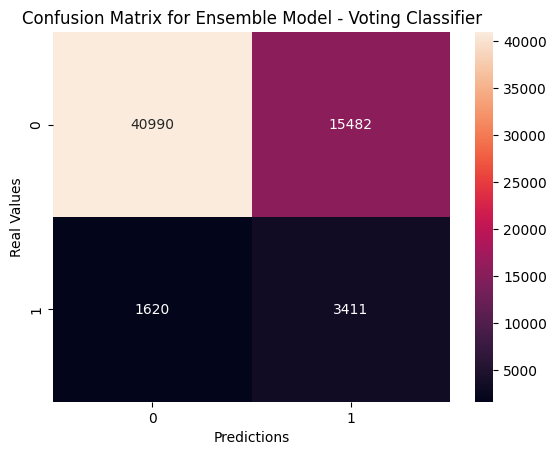

In [ ]:
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="2.0f").set_title(
    "Confusion Matrix for Ensemble Model - Voting Classifier"
)

plt.xlabel("Predictions")

plt.ylabel("Real Values")

- In credit approval, we are more focus on False negative results (1543) than false positive. That is because accepting credit for insolvent client bring much more risk than not accepting the credit for a client without financial problems.
- From model predictions made on 61503 clients, only 1528 patients (~2,5%) might be incorrectly classified, get credit and later on with high probability, their insolvency might causes problems both for the bank and for themselves

### ROC curve
The Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC) are essential evaluation metrics for binary classification models. They measure the model's ability to distinguish between positive and negative classes across different classification thresholds. 

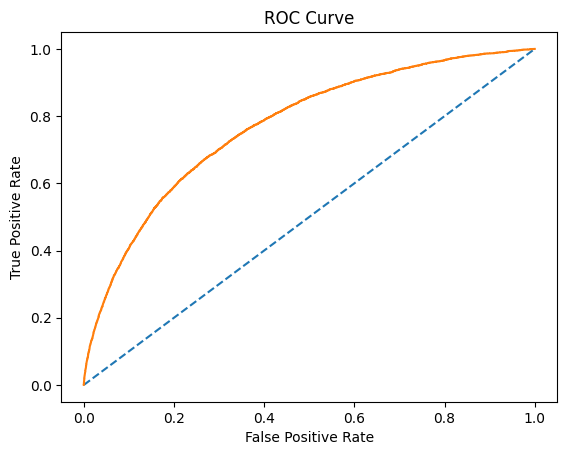

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpt, thresholds = roc_curve(y_val, y_pred_ROC_AUC)

plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(fpr, tpt)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, y_pred_ROC_AUC)

0.770677096660008

- The ROC AUC score is even slightly higher for validation dataset then for training set
- AUC (Area Under the Curve) around 0.77 is believed to be a fair classification. The model has a good ability to differentiate between classes.

## 4. Validating ML performance using kaggle submission
Trained model will be used for kaggle submission

In [31]:
%store -r final_kaggle_test_df

Separating ID column and deleting it:

In [ ]:
ClientId_df = pd.Series(final_kaggle_test_df["SK_ID_CURR"], name="SK_ID_CURR")
X_test = final_kaggle_test_df.drop(columns=["SK_ID_CURR"])

Making a prediction

In [ ]:
for col in X_test.select_dtypes(include="object").columns:
    X_test[col] = X_test[col].astype("category")

y_pred_test = np.round(LightGBM_clf_tuned.predict_proba(X_test)[:, 1], 1)

In [34]:
y_pred_test

array([0.3, 0.4, 0.5, ..., 0.3, 0.2, 0.7])

Creating a tabular form and preparing for kaggle submission

In [35]:
y_pred_tab = pd.Series(y_pred_test, name="TARGET")

Combining predictions with Passanger_id column, which was previously separated

In [36]:
y_pred_submission = np.stack((ClientId_df, y_pred_tab), axis=1)

Creating csv for kaggle submission:

In [ ]:
submission_df = (
    pd.DataFrame(y_pred_submission, columns=["SK_ID_CURR", "TARGET"])

    .astype({"SK_ID_CURR": "int"})
    .sort_values(by="SK_ID_CURR")
)


submission_df.to_csv("submission.csv", index=False)

Importing private kaggle username and api key

In [45]:
import os
from credentials import API_key

os.environ["KAGGLE_USERNAME"] = API_key["username"]
os.environ["KAGGLE_KEY"] = API_key["key"]

Submitting results to kaggle

In [46]:
!kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "Home credit risk predictor"

Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/571k [00:00<?, ?B/s]
  3%|▎         | 16.0k/571k [00:00<00:04, 116kB/s]
 53%|█████▎    | 304k/571k [00:00<00:00, 1.52MB/s]
 84%|████████▍ | 480k/571k [00:00<00:00, 1.24MB/s]
100%|██████████| 571k/571k [00:01<00:00, 511kB/s] 


Checking the results

In [47]:
submission_output = !kaggle competitions submissions -v -q home-credit-default-risk

print("\n".join(submission_output[:4]))

fileName,date,description,status,publicScore,privateScore

submission.csv,2025-06-16 10:25:38.060000,Home credit risk predictor,SubmissionStatus.COMPLETE,0.74955,0.74409



- The final ROC AUC score from kaggle competition is **0,74955** which is reasonable high (the kaggle competition winner had 0,81). Previously, we obtained 0,77 ROC AUC
- The result suggest no or minimal model overfit

## 5. Model deployment

### Saving the model

In [ ]:
import pickle

pickle.dump(LightGBM_clf_tuned, open("model_file.pkl", "wb"))

Deployment steps:
1. Containerizing the Application Using Docker\
`docker build -t IMAGE_NAME:latest .`
2. Pushing the Image to Google Artifact Registry\
Authenticating:\
`gcloud auth configure-docker LOCATION-docker.pkg.dev`\
Tagging:\
`docker tag IMAGE-NAME LOCATION-docker.pkg.dev/PROJECT-ID/REPOSITORY/IMAGE-NAME`\
Pushing:\
`docker push LOCATION-docker.pkg.dev/PROJECT-ID/REPOSITORY/IMAGE-NAME`
3. Container deployment on Google Cloud Run
`gcloud run deploy default-service
      --image LOCATION-docker.pkg.dev/PROJECT-ID/REPOSITORY/IMAGE-NAME
      --region LOCATION
      --port 8080
      --memory 4Gi`

The model was deployed as a user friendly app (POC): https://credit-risk-predictor-450359247412.europe-central2.run.app/